In [ ]:
pip install imblearn -qa


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -a


## [ENG] The main task of news monitoring is to process incoming news streams and identify events that are interesting to users. The assignment requires building a model to detect events in the news related to the delayed introduction of a certain object into operation.

## [RU] Основная задача новостного мониторинга - обрабатывать входящий поток новостей, находя в них интересные пользователям события. В задании предлагается построить модель для выявления в новости события, соответствующего задержке ввода некоторого объекта в эксплуатацию


In [ ]:
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

import pandas as pd
import random, time
from babel.dates import format_date, format_datetime, format_time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE, RandomOverSampler



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)

In [ ]:
path ="sample_data/train_data.csv"

# Read file
df = pd.read_csv(path, index_col=0)

## Get familiar with the data

In [ ]:
df.sample(5)

,sentence,label
941,"Тогда же, в марте 2019-го, региональные власти...",0
988,Общий бюджет стройки был увеличен на 10% до 38...,0
405,Однако местные власти не смогли найти подходящ...,0
722,Сама компания находится в стадии процедуры бан...,0
1614,Стройка будет идти за счет банковских кредитов.,0


In [ ]:
print(f"Positive: {df['sentence'][52]}\nNegative: {df['sentence'][680]}")

Positive: Глава минобрнауки Челябинской области Александр Кузнецов пояснил, что в срыве сроков подготовки школы к 1 сентября виноват, главным образом, строительный подрядчик.
Negative: Стремясь привлечь внимание будущих покупателей жилья, компания поначалу действует весьма активно, «но завершает строительство крайне медленно».


### По mean виден сильный дизбаланс классов

In [ ]:
df.describe()

,label
count,1669.000000
mean,0.197124
std,0.397946
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1669 entries, 0 to 1668
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  1669 non-null   object
 1   label     1669 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 103.7+ KB


## Get to know the data

<Axes: ylabel='Count'>

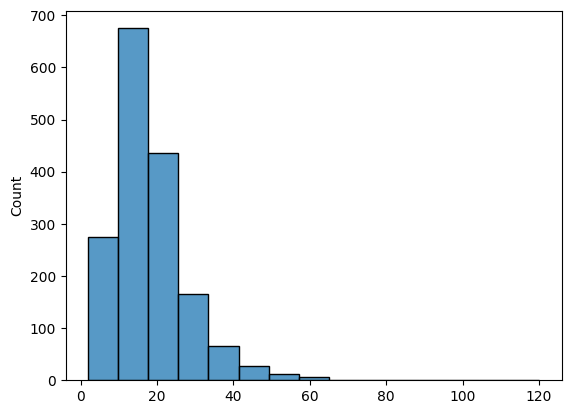

In [ ]:
# get length of all sentences in the dataframe
seq_len = [len(i.split()) for i in df['sentence']]

sns.histplot(seq_len, bins=15)

In [ ]:
df[df["label"] != 0]

,sentence,label
0,Срыв сроков строительства зоопарка оценили в 1...,1
1,"По данным Генпрокуратуры РФ, в 2014-2018 годах...",1
2,"Обвиняли в этом столичный акимат, который сорв...",1
3,Запуск циклотронного центра ядерной медицины н...,1
4,Сроки сдачи объекта несколько раз переносились.,1
...,...,...
324,"Бизнесвумен взыскала с «Интеко» 1,5 млн за сры...",1
325,"Арбитражный суд Москвы взыскал 1,5 миллиона ру...",1
326,Трутнев раскритиковал срыв сроков сдачи объект...,1
327,"Глава австрийской OMV Райнер Зеле говорил, что...",1


<Axes: xlabel='label', ylabel='count'>

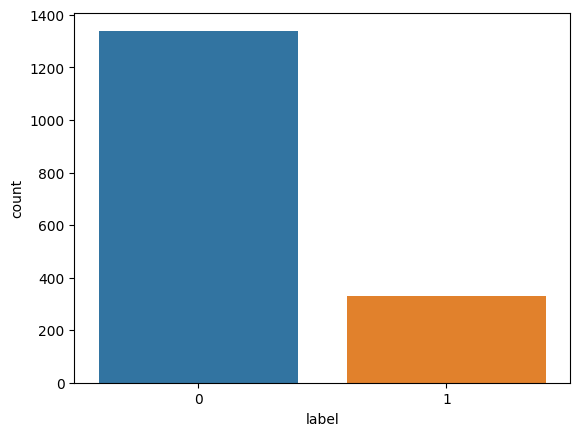

In [ ]:
# Plot the count of positive and negative samples
sns.countplot(x=df["label"])

### Wordclouds

#### All sentences

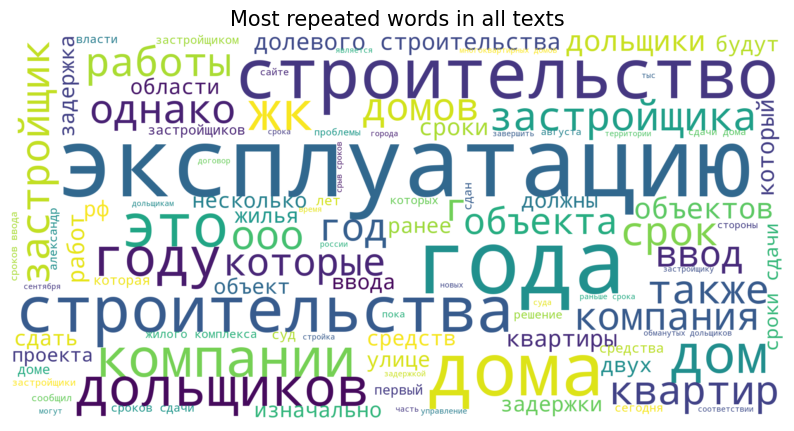

In [ ]:
# Wordcloud of text

# Get stopwords
# Define nltk stopwords in english
stop_words = stopwords.words('russian')

# Get a string of all the texts available
data_text = ",".join(txt.lower() for txt in df.sentence)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      stopwords=stop_words,
                      scale=5,
                      background_color="white").generate(data_text)

# Display the generated image:
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most repeated words in all texts',fontsize=15)
plt.show()

Sentences that state the delay of some object.

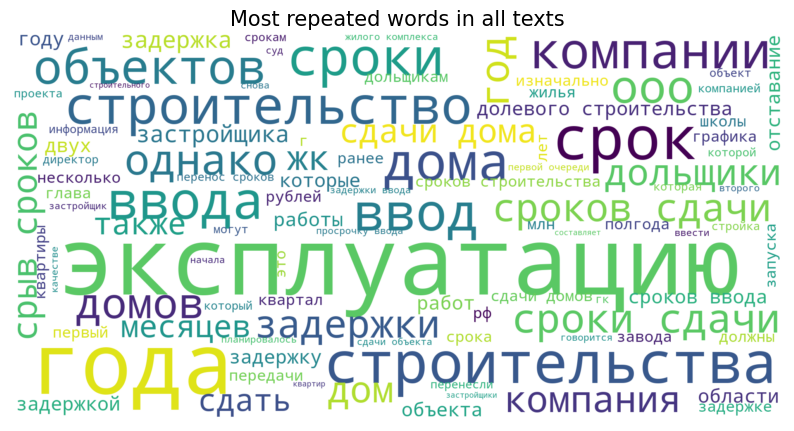

In [ ]:
sentences_delay = ",".join(sentence.lower() for sentence in df.sentence[df.label == 1])


# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      stopwords=stop_words,
                      scale=5,
                      background_color="white").generate(sentences_delay)

# Display the generated image:
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most repeated words in all texts',fontsize=15)
plt.show()

#### Sentences that do not state the delay

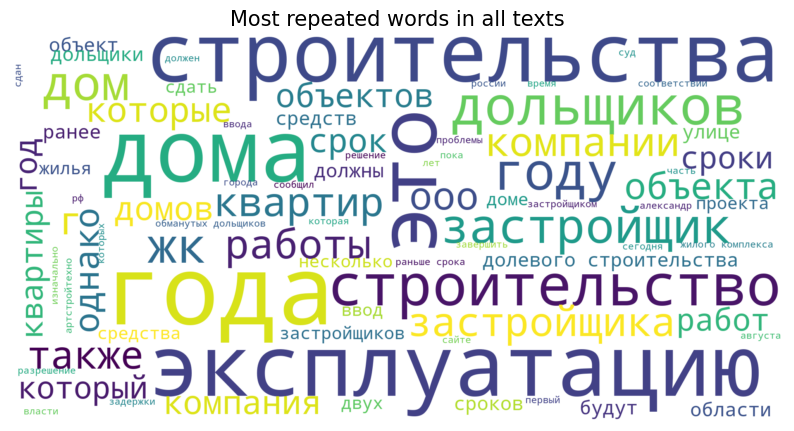

In [ ]:
sentences_no_delay = ",".join(sentence.lower() for sentence in df.sentence[df.label == 0])


# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      stopwords=stop_words,
                      scale=5,
                      background_color="white").generate(sentences_no_delay)

# Display the generated image:
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most repeated words in all texts',fontsize=15)
plt.show()

In [ ]:
#  Preprocess train dataset
# remove special characters from sentence column
df.sentence = df.sentence.str.replace('[#,@,&]', '')
# Remove digits
df.sentence = df.sentence.str.replace('\d*','')
#Remove www
df.sentence = df.sentence.str.replace('w{3}','')
# remove urls
df.sentence = df.sentence.str.replace("http\S+", "")
# remove multiple spaces with single space
df.sentence = df.sentence.str.replace('\s+', ' ')
#remove all single characters
df.sentence = df.sentence.str.replace(r'\s+[a-zA-Z]\s+', '')

# Remove russian stopwords
df['sentence'] = df['sentence'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

<ipython-input-51-db15f6fa7279>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df.sentence = df.sentence.str.replace('[#,@,&]', '')
<ipython-input-51-db15f6fa7279>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df.sentence = df.sentence.str.replace('\d*','')
<ipython-input-51-db15f6fa7279>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df.sentence = df.sentence.str.replace('w{3}','')
<ipython-input-51-db15f6fa7279>:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df.sentence = df.sentence.str.replace("http\S+", "")
<ipython-input-51-db15f6fa7279>:11: FutureWarning: The default value of regex will change from True to False in a future version.
  df.sentence = df.sentence.str.replace('\s+', ' ')
<ipython-input-51-db15f6fa7279>:13: FutureWarning: The default value of regex will change f

## Train test split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df['sentence'],
                                                      df['label'],
                                                     test_size=0.25,
                                                     shuffle=True,
                                                     random_state=42)

To deal with class inbalance lets oversample minority

In [ ]:
ros = RandomOverSampler(random_state=seed_val)

x_train_reshaped = x_train.to_numpy().reshape(-1, 1)

x_train_ros, y_train_ros = ros.fit_resample(x_train_reshaped, y_train)

In [ ]:
x_train_ros

array([['Выявили время проверки ноябре года.'],
       ['То своей претензии передаче оплаченного товара можете установить -дневный срок исполнения.'],
       ['Учитывая репутацию застройщика происходящее сегодня других строительных площадках «Серебряного ключа» дольщики естественно обеспокоены.'],
       ...,
       ['В прошлом году многие застройщики столкнулись ряд требований вводе эксплуатацию невозможно исполнить определенный период времени например летом зимой.'],
       ['В компании "ВсевИнвестСтрой" подтвердили значительную задержку ввод эксплуатацию обозначив двухлетнюю.'],
       ['Все делается - это переносятся сроки допсоглашения дольщиками которые станут гарантией завершения строительства домов заключаются.']],
      dtype=object)

In [ ]:
x_train_ros = np.concatenate(x_train_ros)

In [ ]:
# Check if a GPU is available
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
!nvidia-smi --query-gpu=gpu_name --format=csv,noheader,nounits

NVIDIA A100-SXM4-40GB


<Axes: xlabel='label', ylabel='count'>

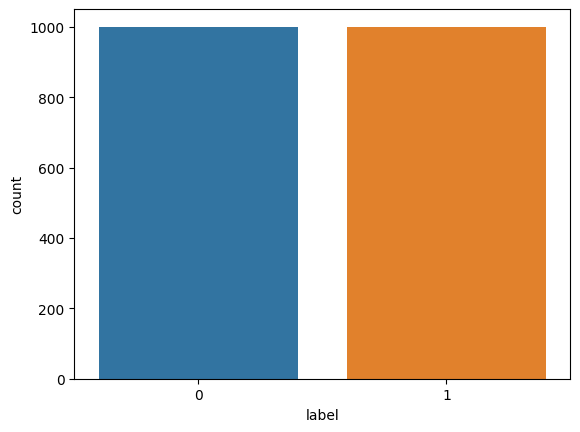

In [ ]:
# Plot new distribution
sns.countplot(x=y_train_ros)

## Logistic regression

The upcoming section involves training a Logistic Regression model through a Pipeline that incorporates TfidfVectorizer and LogisticRegression. Moreover, I will employ GridSearchCV on the Pipeline to determine the most suitable parameters for the model. While this approach guarantees optimal parameters, it may be time-consuming.

In [ ]:
# Create a Pipeline with the TfidfVectorizer and LogisticRegression model
LR_pipeline = Pipeline(steps = [('tf', TfidfVectorizer()),
                                ('log_reg', LogisticRegression())]) # initialize TfidfVectorizer and LogisticRegression


# Create Parameter Grid
cv_grid = {
 'tf__max_features' : [500, 1000, 2000, 3000],
 'tf__ngram_range' : [(1,1),(1,2),(1,3)],
 'tf__use_idf' : [True, False],
 'log_reg__penalty' : ['l1', 'l2', 'elasticnet', None],
 'log_reg__C': [ 0.1, 0.5, 1.0],
 'log_reg__class_weight' : ['balanced', None],
}

# Apply GridSearch to Pipeline to find the best parameters
LR_grid_search = GridSearchCV(LR_pipeline, cv_grid, scoring='accuracy', cv=2, n_jobs=-1, verbose=2)

In [ ]:
LR_grid_search.fit(x_train_ros, y_train_ros)

Fitting 2 folds for each of 576 candidates, totalling 1152 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
576 fits failed out of a total of 1152.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
288 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dua

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('log_reg', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'log_reg__C': [0.1, 0.5, 1.0],
                         'log_reg__class_weight': ['balanced', None],
                         'log_reg__penalty': ['l1', 'l2', 'elasticnet', None],
                         'tf__max_features': [500, 1000, 2000, 3000],
                         'tf__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'tf__use_idf': [True, False]},
             scoring='accuracy', verbose=2)

In [ ]:
LR_grid_search.best_params_

{'log_reg__C': 0.1,
 'log_reg__class_weight': 'balanced',
 'log_reg__penalty': None,
 'tf__max_features': 1000,
 'tf__ngram_range': (1, 2),
 'tf__use_idf': False}

In [ ]:
print('Score of train set', LR_grid_search.score(x_train_ros, y_train_ros))
print('Score of test set',LR_grid_search.score(x_test, y_test))

Score of train set 0.9995
Score of test set 0.8564593301435407


## Finetuning

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Define the TfidfVectorizer with the best parameters
tfidf_vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2), use_idf=False)

# Define the LogisticRegression model with the best parameters
logistic_regression = LogisticRegression(C=0.5, class_weight='balanced', penalty=None, tol=1e-6)

# Create a Pipeline to combine the vectorizer and the classifier
LR_pipeline = Pipeline([
    ('tf', tfidf_vectorizer),    # TF-IDF Vectorizer
    ('log_reg', logistic_regression)  # Logistic Regression Classifier
])

# Fit the pipeline to your training data
LR_pipeline.fit(x_train_ros, y_train_ros)  # Assuming x_train and y_train are your training data and labels

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


Pipeline(steps=[('tf',
                 TfidfVectorizer(max_features=1000, ngram_range=(1, 2),
                                 use_idf=False)),
                ('log_reg',
                 LogisticRegression(C=0.5, class_weight='balanced',
                                    penalty=None, tol=1e-06))])

In [ ]:
print('Accuracy of train set', LR_pipeline.score(x_train_ros, y_train_ros))
print('Accuracy of test set',LR_pipeline.score(x_test, y_test))

Score of train set 0.9995
Score of test set 0.8564593301435407


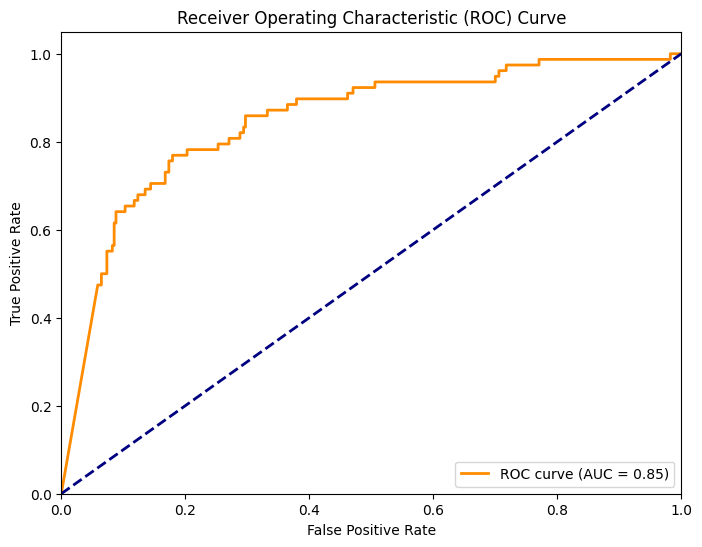

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt

# Assuming LR_pipeline is your trained logistic regression model
# and x_test is your test data
y_pred_proba = LR_pipeline.predict_proba(x_test)[:, 1]  # Probability of positive class

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the AUC-ROC score
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


## XGBoost

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Create a Pipeline to combine the vectorizer and the classifier
XGB_pipeline = Pipeline([
    ('tf',  TfidfVectorizer()),    # TF-IDF Vectorizer
    ('xgb', GradientBoostingClassifier(random_state=seed_val))  # Logistic Regression Classifier
])


# Create Parameter Grid
cv_grid = {
 'tf__max_features' : [1000, 2000, 3000],
 'tf__ngram_range' : [(1,1),(1,2)],
 'tf__use_idf' : [True],
 'xgb__n_estimators': [50, 100, 200],
 'xgb__learning_rate': [0.01, 0.05, 0.1],
 'xgb__max_depth': [2, 3],
}

# Apply GridSearch to Pipeline to find the best parameters
XGB_grid_search = GridSearchCV(XGB_pipeline, cv_grid, scoring='accuracy', cv=2, n_jobs=-1, verbose=2)

In [ ]:
XGB_grid_search.fit(x_train, y_train)

Fitting 2 folds for each of 108 candidates, totalling 216 fits


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('xgb',
                                        GradientBoostingClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'tf__max_features': [1000, 2000, 3000],
                         'tf__ngram_range': [(1, 1), (1, 2)],
                         'tf__use_idf': [True],
                         'xgb__learning_rate': [0.01, 0.05, 0.1],
                         'xgb__max_depth': [2, 3],
                         'xgb__n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=2)

In [ ]:
XGB_grid_search.best_params_

{'tf__max_features': 1000,
 'tf__ngram_range': (1, 2),
 'tf__use_idf': True,
 'xgb__learning_rate': 0.1,
 'xgb__max_depth': 3,
 'xgb__n_estimators': 100}

In [ ]:
print('Accuracy of train set', XGB_grid_search.score(x_train_ros, y_train_ros))
print('Accuracy of test set',XGB_grid_search.score(x_test, y_test))

Accuracy of train set 0.987
Accuracy of test set 0.8803827751196173


In [ ]:
# Create a Pipeline to combine the vectorizer and the classifier
XGB_pipeline = Pipeline([
    ('tf',  TfidfVectorizer()),    # TF-IDF Vectorizer
    ('xgb', GradientBoostingClassifier(random_state=seed_val))  # Logistic Regression Classifier
])


# Create Parameter Grid
cv_grid = {
 'tf__max_features' : [3000, 5000, 10000],
 'tf__ngram_range' : [(1,2)],
 'xgb__n_estimators': [200, 500, 1000],
 'xgb__learning_rate': [0.05, 0.1, 0.2],
 'xgb__max_depth': [3, 4, 6],
}

# Apply GridSearch to Pipeline to find the best parameters
XGB_grid_search = GridSearchCV(XGB_pipeline, cv_grid, scoring='accuracy', cv=3, n_jobs=-1, verbose=2)

In [ ]:
XGB_grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('xgb',
                                        GradientBoostingClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'tf__max_features': [3000, 5000, 10000],
                         'tf__ngram_range': [(1, 2)],
                         'xgb__learning_rate': [0.05, 0.1, 0.2],
                         'xgb__max_depth': [3, 4, 6],
                         'xgb__n_estimators': [200, 500, 1000]},
             scoring='accuracy', verbose=2)

In [ ]:
XGB_grid_search.best_params_

{'tf__max_features': 3000,
 'tf__ngram_range': (1, 2),
 'xgb__learning_rate': 0.05,
 'xgb__max_depth': 3,
 'xgb__n_estimators': 500}

## As we can see we achieved 3% higher accuracy for XGBoost. That is a good result if we compare it to logistic regression. Further improvements may be possible by using BERT classifier, SMOTE oversampling and more feature engineering.

In [ ]:
print('Accuracy of train set', XGB_grid_search.score(x_train_ros, y_train_ros))
print('Accuracy of test set',XGB_grid_search.score(x_test, y_test))

Accuracy of train set 0.987
Accuracy of test set 0.8803827751196173


In [ ]:
df = pd.read_csv("sample_data/test_data.csv", index_col=0)

df["sentence"] = df['title'].str.cat(df['text'], sep='\n')

#  Preprocess train dataset
# remove special characters from sentence column
df.sentence = df.sentence.str.replace('[#,@,&]', '')
# Remove digits
df.sentence = df.sentence.str.replace('\d*','')
#Remove www
df.sentence = df.sentence.str.replace('w{3}','')
# remove urls
df.sentence = df.sentence.str.replace("http\S+", "")
# remove multiple spaces with single space
df.sentence = df.sentence.str.replace('\s+', ' ')
#remove all single characters
df.sentence = df.sentence.str.replace(r'\s+[a-zA-Z]\s+', '')

# Remove russian stopwords
def save_split(obj):
    if isinstance(obj, str):
        return obj.split()
    else:
        return obj

df['sentence'] = df['sentence'].astype('str')
df['sentence'] = df['sentence'].apply(lambda x: ' '.join([word for word in save_split(x) if word not in (stop_words)]))

<ipython-input-83-b1a869718585>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df.sentence = df.sentence.str.replace('[#,@,&]', '')
<ipython-input-83-b1a869718585>:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df.sentence = df.sentence.str.replace('\d*','')
<ipython-input-83-b1a869718585>:11: FutureWarning: The default value of regex will change from True to False in a future version.
  df.sentence = df.sentence.str.replace('w{3}','')
<ipython-input-83-b1a869718585>:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df.sentence = df.sentence.str.replace("http\S+", "")
<ipython-input-83-b1a869718585>:15: FutureWarning: The default value of regex will change from True to False in a future version.
  df.sentence = df.sentence.str.replace('\s+', ' ')
<ipython-input-83-b1a869718585>:17: FutureWarning: The default value of regex will change

In [ ]:
predictions = XGB_grid_search.predict(df['sentence'])

df['label'] = predictions


# Save the result to a CSV file
df.to_csv('test_data.csv', index=False)

from google.colab import files
files.download('test_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>